1) Multi-regression output problem --> predict two labels: longitude and latitude

2) Re-write problem as multi-class problem through clustering
To define the classes, the last points per trip from the training data will be divided into clusters. When we have a large enough number of clusters, the clusters should be small enough to have their points close to their centroids. 

K-Means is a good approach as it minimizes the sum of squared distances within the cluster. Also it scales well to a large number of clusters. 

So the approach then predicts: **Probability of final destination of a trip being located in a specific cluster**

Steps:
- Get optimal number of clusters with help of interia
- Generate clusters with K-Means for each trip in training data
- Predict cluster for each trip in testing data
- Get centroids for each cluster 
- Calculate distance from points in cluster to centroid to evaluate

In [5]:
is_sagemaker_notebook = True

In [1]:
!pip install dask_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 11.9 MB/s eta 0:00:00


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import awswrangler as wr
import random

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
!pip install numpy==1.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-fft 1.3.8 requires mkl, which is not installed.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.1.1 which is incompatible.
seaborn 0.13.0 requires numpy!=1.24.0,>=1.20, but you have numpy 1.24.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.1.1 which is incompatible.


In [4]:
from sklearn.cluster import KMeans
import dask.array as da
from dask_ml import cluster
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
if is_sagemaker_notebook:
    prefix = "/home/ec2-user/SageMaker"
else:
    prefix = "/Users/Q619505/PycharmProjects"

utils_path = os.path.join(f'{prefix}/ml-project-taxi-prediction/src/utils/')
pp_path = os.path.join(f'{prefix}/ml-project-taxi-prediction/src/preprocessing/')

if utils_path not in sys.path:
    sys.path.append(utils_path)

if pp_path not in sys.path:
    sys.path.append(pp_path)

In [7]:
from utils import *

In [8]:
train_data = wr.s3.read_parquet('s3://think-tank-casestudy/preprocessed_data/train_data_preprocess.parquet')
test_data = wr.s3.read_parquet('s3://think-tank-casestudy/preprocessed_data/test_data_preprocess.parquet')

In [9]:
test_data.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,weather,n_coordinate_points,total_flight_time_minutes,start_point,dest_point,total_distance_km,sequence
0,T1,B,NaN,15.0,20000542,Foggy,11,2.50,"[-8.585676, 41.148522]","[-8.584884, 41.146623]",0.226606,"[-8.585676, 41.148522, -8.585712, 41.148639, -..."
1,T2,B,NaN,57.0,20000108,Cloudy,40,9.75,"[-8.610876, 41.14557]","[-8.601894, 41.163597]",2.219367,"[-8.610876, 41.14557, -8.610858, 41.145579, -8..."
2,T3,B,NaN,15.0,20000370,Foggy,40,9.75,"[-8.585739, 41.148558]","[-8.574903, 41.167719]",2.426982,"[-8.585739, 41.148558, -8.58573, 41.148828, -8..."
3,T6,A,42612.0,NaN,20000607,Cloudy,137,34.00,"[-8.630613, 41.178249]","[-8.62641, 41.171958]",0.834711,"[-8.630613, 41.178249, -8.630613, 41.178249, -..."
4,T7,B,NaN,15.0,20000310,Sunny,24,5.75,"[-8.585622, 41.148918]","[-8.582049, 41.153778]",0.665869,"[-8.585622, 41.148918, -8.58564, 41.1489, -8.5..."


In [10]:
def extract_lat_lon(data, column_):
    data[column_+'_LON'] = data[column_].apply(lambda value: value[0])
    data[column_+'_LAT'] = data[column_].apply(lambda value: value[1])
    return data

In [11]:
train_data = extract_lat_lon(train_data,'start_point')
test_data = extract_lat_lon(test_data,'start_point')

train_data = extract_lat_lon(train_data,'dest_point')
test_data = extract_lat_lon(test_data,'dest_point')

In [16]:
X = np.vstack(train_data.dest_point)
# transform destintion point to dask format
X_da = da.from_array(X)

- Inertia/sum of squared distance shows still significant reduction for 4000 clusters, therefore choose n_clusters = 4000
- Due to high execution time more iterations are not considered

In [17]:
#inertia_per_k = [(k, KMeans(n_clusters=k, init='k-means++', verbose=True, random_state=1).fit(X_da).inertia_)
#  for k in range(1000,5000,1000)]

One iteration is sufficient as single points need to be clustered, the nature of the data already provides the clusters

In [19]:
random.seed(5)

In [20]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clustering', KMeans(n_clusters = 4000,
                                       init ='k-means++',
                                       n_init = 1, 
                                       verbose=True,
                                       random_state=1
                                      )
                 )])

In [ ]:
X['cluster_label'] = pipe.fit_predict(X_da)
centers_scaled = pipe[1].cluster_centers_

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [19]:
centers = pipe[0].inverse_transform(centers_scaled)

In [20]:
centers = pd.DataFrame(centers, columns=['CENTER_LON','CENTER_LAT'])

In [21]:
centers = centers.reset_index()

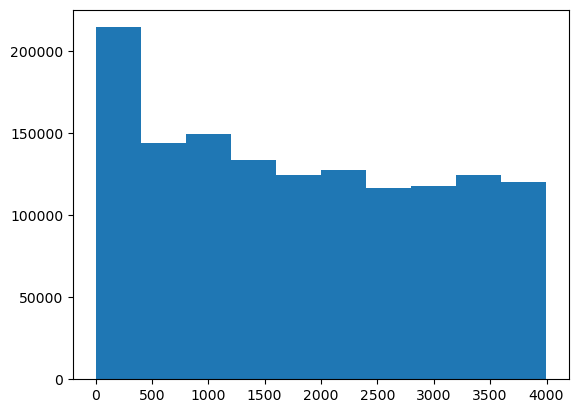

In [22]:
plt.hist(X.cluster_label)
plt.show()

In [23]:
X_test = test_data[test_data.columns[-3:-1]]
X_da_test = da.from_array(np.array(X_test))
X_test['CLUSTER_LABEL'] = pipe.predict(X_da_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/tmp/ipykernel_8693/1233280834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['CLUSTER_LABEL'] = pipe.predict(X_da_test)


In [24]:
train_data['CLUSTER_LABEL'] = X['cluster_label']
test_data['CLUSTER_LABEL'] = X_test['CLUSTER_LABEL']

test_data = pd.merge(test_data, centers[['index','CENTER_LON','CENTER_LAT']], 
                           how='left', 
                           left_on='CLUSTER_LABEL',
                           right_on='index')
train_data = pd.merge(train_data, centers[['index','CENTER_LON','CENTER_LAT']], 
                           how='left', 
                           left_on='CLUSTER_LABEL',
                           right_on='index')

In [25]:
n_cluster = train_data.CLUSTER_LABEL.nunique()

In [26]:
wr.s3.to_parquet(df=train_data, path=f's3://think-tank-casestudy/preprocessed_data/n_cluster_{n_cluster}/train_data_clustered.parquet')
wr.s3.to_parquet(df=test_data, path=f's3://think-tank-casestudy/preprocessed_data/n_cluster_{n_cluster}/test_data_clustered.parquet')

{'paths': ['s3://think-tank-casestudy/preprocessed_data/n_cluster_4000/test_data_clustered.parquet'],
 'partitions_values': {}}